In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
from edward.util import rbf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io
import mvn_kron_autograd
import random

%matplotlib inline


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# util functions
def chunk(xs, n):
    ys = list(xs)
    random.shuffle(ys)
    ylen = len(ys)
    size = int(ylen / n)
    chunks = [ys[0+size*i : size*(i+1)] for i in range(n)]
    leftover = ylen - size*n
    edge = size*n
    for i in range(leftover):
        chunks[i%n].append(ys[edge+i])
    return chunks

def gen_struct(N,t):
    rr = np.random.randint(100, size=(1, t))[0]+1
    nn = chunk(range(N), t)
    dd = np.zeros(N)
    for i in range(t):
        for j in range(len(nn[i])):
            dd[nn[i][j]] = rr[i]
    return dd

def const(x):
    x = tf.constant(x,dtype=tf.float32)
    return x


In [3]:
N = 20  # number of data points or number of odors
D = 50  # data dimensionality or number of neurons
K = 2  # latent dimensionality
T = 10 # number of trials

Ngrid = 20
Nall = Ngrid**2 + N
prior_l = 0.8 # lengthscale for Kprior
prior_sig_f = 1 # marginal var for Kprior
l = 1 # lengthscale for Kz
sig_f = 2 # marginal var for Kz
sig_n = 1
rr = .8
R = 2


In [4]:
# generate latent z
tgrid = np.linspace(-5, 5, num=N).reshape(-1,1)
sess = ed.get_session()
with sess.as_default():
    Kprior = rbf(const(tgrid),lengthscale=const(prior_l),variance=const(prior_sig_f)).eval()

z_mu = np.zeros(N)
z_cov = 0.1*np.eye(N) + Kprior
z = np.random.multivariate_normal(z_mu, z_cov, K).T
print(z.shape)

zgridx,zgridy = np.meshgrid(np.linspace(z[:,0].min(), z[:,0].max(), num=Ngrid), 
                            np.linspace(z[:,1].min(), z[:,1].max(), num=Ngrid))
zgrid = np.vstack((zgridx.reshape(1,-1),zgridy.reshape(1,-1))).T
zall = np.vstack((z,zgrid))

(20, 2)


In [5]:
# generate observation x from z
with sess.as_default():
    Kzall = rbf(const(zall),lengthscale=const(l),variance=const(sig_f)).eval()

Kz = Kzall[:N,:N]
Kzgrid = Kzall[N:,N:]
mk = np.sqrt(np.max(Kz))

# construct covariance across neurons and odors
Sigma_odor = np.random.randn(N,R)
dd = gen_struct(N,5)
dd = dd/np.max(dd)*np.max(Sigma_odor)
Sigma_odor = Sigma_odor@Sigma_odor.T + np.tile(dd,(R,1)).T@np.tile(dd,(R,1))
Sigma_odor = Sigma_odor/np.max(Sigma_odor)*mk*rr # correlated low-rank matrix
so = np.abs(np.random.randn(N))
so = so/np.max(so)*mk*rr # diagonal noise

# Sigma_neuron = np.eye(D)
Sigma_neuron = np.random.randn(D,R)
dd = gen_struct(D,11)
dd = dd/np.max(dd)*np.max(Sigma_neuron)
Sigma_neuron = Sigma_neuron@Sigma_neuron.T + np.tile(dd,(R,1)).T@np.tile(dd,(R,1))
Sigma_neuron = Sigma_neuron/np.max(Sigma_neuron)*mk*rr # correlated low-rank matrix
sn = np.abs(np.random.randn(D))
sn = sn/np.max(sn)*mk*rr # diagonal noise

# generate mean firing rate (mfr) x0
Kn = np.eye(D)
ssgrid = mvn_kron_autograd.matnorm_sample(np.zeros((Nall,D)),Kzall,Kn,np.zeros((Nall,Nall)),np.zeros((D,D)),1)
x0 = ssgrid.reshape(Nall,-1)[:N,:]
xgrid = ssgrid.reshape(Nall,-1)[N:,:]

# generate observed firing rate (ofr) x from x0 using the noise covariance
x = mvn_kron_autograd.matnorm_sample(x0,Sigma_odor+np.diag(so),Sigma_neuron+np.diag(sn),np.zeros((N,N)),np.zeros((D,D)),T)

# sample covariance across all T trials
C = np.cov(x.T)
print(C.shape)


(1000, 1000)


Text(0.5,1,'latent')

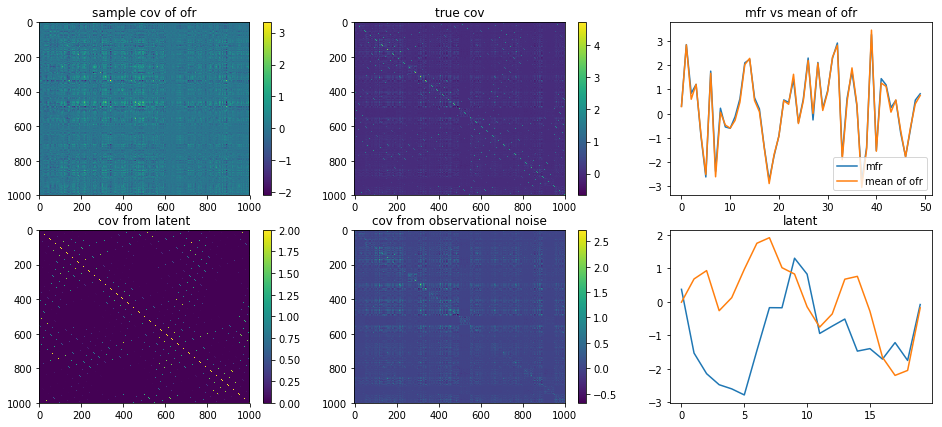

In [6]:
# visualize
plt.subplots(2,3,figsize=(16,7))
plt.subplot(2,3,1)
plt.imshow(C,aspect='auto')
plt.title('sample cov of ofr')
plt.colorbar()
plt.subplot(2,3,2)
plt.imshow(np.kron(Kz,Kn)+np.kron(Sigma_odor+np.diag(so),Sigma_neuron+np.diag(sn)),aspect='auto')
plt.title('true cov')
plt.colorbar()
plt.subplot(2,3,3)
plt.plot(x0.flatten()[:50], label='mfr')
plt.plot(np.mean(x,0)[:50], label='mean of ofr')
plt.title('mfr vs mean of ofr')
plt.legend()

plt.subplot(2,3,4)
plt.imshow(np.kron(Kz,Kn),aspect='auto')
plt.title('cov from latent')
plt.colorbar()
plt.subplot(2,3,5)
plt.imshow(np.kron(Sigma_odor+np.diag(so),Sigma_neuron+np.diag(sn)),aspect='auto')
plt.title('cov from observational noise')
plt.colorbar()
plt.subplot(2,3,6)
plt.plot(z)
plt.title('latent')


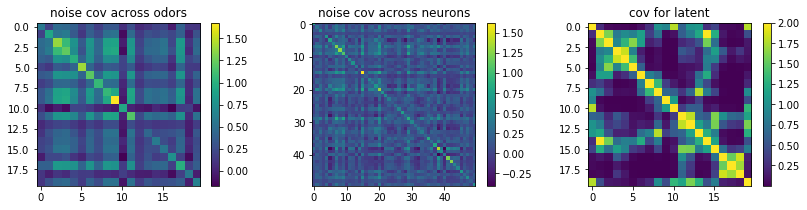

In [7]:
# more visualization of cov
plt.subplots(1,3,figsize=(14,3))
plt.subplot(1,3,1)
plt.imshow(Sigma_odor+np.diag(so))
plt.title('noise cov across odors')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(Sigma_neuron+np.diag(sn))
plt.title('noise cov across neurons')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(Kz)
plt.title('cov for latent')
plt.colorbar()

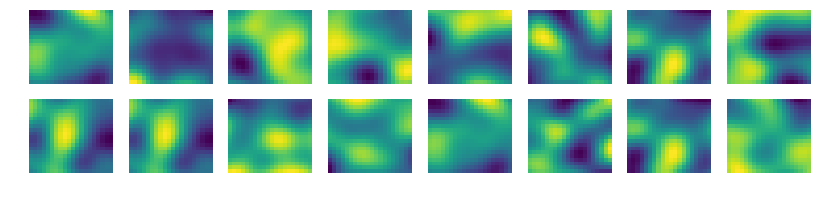

In [8]:
# tuning curve of 16 randomly selected neurons
plt.subplots(2,8,figsize=(14,3))
ii = np.random.randint(0,D,16)
extent = z[:,0].min(), z[:,0].max(), z[:,1].min(), z[:,1].max()
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(xgrid[:,ii[i]].reshape(Ngrid,Ngrid),extent=extent,aspect='auto')
    plt.axis('off')

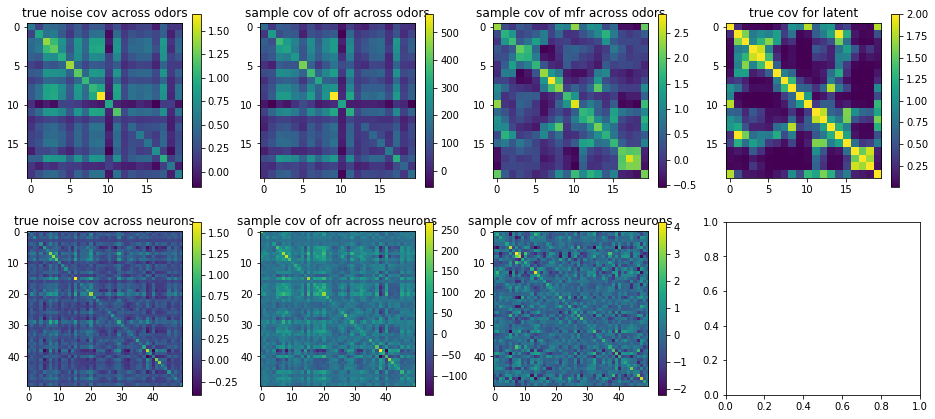

In [9]:
cnr = Sigma_odor + np.diag(so)
cnc = Sigma_neuron + np.diag(sn)
csr = np.cov(x0)
csc = np.cov(x0.T)

x1 = x - np.mean(x,0)
x1_neuro = x1.reshape(T,N,D).reshape(-1,D)
x1_odor = x1.reshape(T,N,D).swapaxes(1,2).reshape(-1,N)
cdr = x1_odor.T @ x1_odor
cdc = x1_neuro.T @ x1_neuro

plt.subplots(2,4,figsize=(16,7))
plt.subplot(2,4,1)
plt.imshow(cnr)
plt.title('true noise cov across odors')
plt.colorbar()
plt.subplot(2,4,2)
plt.imshow(cdr)
plt.title('sample cov of ofr across odors')
plt.colorbar()
plt.subplot(2,4,3)
plt.imshow(csr)
plt.title('sample cov of mfr across odors')
plt.colorbar()
plt.subplot(2,4,4)
plt.imshow(Kz)
plt.title('true cov for latent')
plt.colorbar()

plt.subplot(2,4,5)
plt.imshow(cnc)
plt.title('true noise cov across neurons')
plt.colorbar()
plt.subplot(2,4,6)
plt.imshow(cdc)
plt.title('sample cov of ofr across neurons')
plt.colorbar()
plt.subplot(2,4,7)
plt.imshow(csc)
plt.title('sample cov of mfr across neurons')
plt.colorbar()



In [10]:
scipy.io.savemat('syn_2d.mat',mdict={'N':N,'D':D,'T':T,'x_true0':x0,'x_true':x,'xgrid':xgrid,'z_true':z, \
                                       'zgrid':zgrid,'tgrid':tgrid,'Kz':Kz,'Sigma_neuron':Sigma_neuron, \
                                       'Sigma_odor':Sigma_odor,'sn':sn,'so':so})